## Import des packages

In [64]:
from product_sub.infrastructure.dataset_builder import DatasetBuilder
from product_sub.domain.pipeline_creator import PipelineCreator
import product_sub.settings as stg

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import SVC


from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## Import des données et pipelines

In [ ]:
dataset_merged = DatasetBuilder(
    filename_bank=stg.FILENAME_BANK, filename_socio=stg.FILENAME_SOCIO_ECO
).create_dataset()
X = dataset_merged.drop(columns=stg.COL_RAW_SUBSCRIPTION)
y = dataset_merged[stg.COL_RAW_SUBSCRIPTION].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=stg.RANDOM_STATE
)

custom_pipeline_accessor = PipelineCreator()
preprocessor = custom_pipeline_accessor.preprocessor

clf = Pipeline(steps=[ ('preprocessor' , preprocessor),
                           ('rf',  RandomForestClassifier()) ])
rf = RandomForestClassifier()
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## OverSampling

In [42]:
smt = SMOTE(sampling_strategy=0.4,random_state=stg.RANDOM_STATE)
#X_train, y_train = smt.fit_resample(X_train,y_train)

In [14]:
grid_params_rf = [{
                'criterion': ['entropy','gini'],
                'min_samples_leaf': [40,60, 80],
                'max_depth': [15,25,30],
                'min_samples_split': [3, 5, 10],
                'n_estimators' : [60, 70]
                }]
cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
search = GridSearchCV(rf, grid_params_rf, n_jobs=-1, refit=True)
search.fit(X_resampled, y_resampled)
y_train

array([1, 0, 0, ..., 0, 0, 0])

In [15]:
search.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'min_samples_leaf': 40,
 'min_samples_split': 3,
 'n_estimators': 60}

## Exemple under & over avec SMOTEEIN

In [ ]:
smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [19]:
##WITH SMOTE

#good_rf = RandomForestClassifier(criterion="entropy", max_depth=15, min_samples_leaf=40, min_samples_split=3, n_estimators=60)
#good_rf.fit(X_train, y_train)

##WITHOUT SMOTE
good_rf = RandomForestClassifier()
good_rf.fit(X_train, y_train)

RandomForestClassifier()

In [34]:
# WITH UNDER&OVER
good_rf = RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=40, min_samples_split=3, n_estimators=60)
good_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_leaf=40,
                       min_samples_split=3, n_estimators=60)

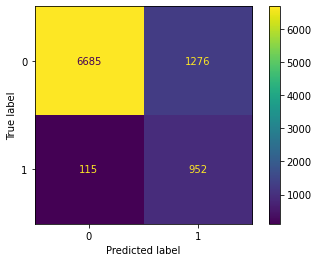

In [27]:
plot_confusion_matrix(good_rf,X_test, y_test)

In [60]:
r=[0.1,1,10]
pg_svm=[{'C':r, 'kernel':['linear']}]
#        {'C':r, 'gamma':r, 'kernel':['rbf']}]
svm = SVC(random_state=stg.RANDOM_STATE)

cv = StratifiedKFold(shuffle=True, n_splits=5, random_state=stg.RANDOM_STATE)
gs_svm=GridSearchCV(estimator= svm,
               param_grid= pg_svm,
               scoring='accuracy',
                refit=True,
               cv=2)
gs_svm.fit(X_resampled, y_resampled)

GridSearchCV(cv=2, estimator=SVC(random_state=42),
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear']}],
             scoring='accuracy')

In [65]:
y_true, y_pred = y_test, gs_svm.predict(X_test)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      7961
           1       0.42      0.86      0.56      1067

    accuracy                           0.84      9028
   macro avg       0.70      0.85      0.73      9028
weighted avg       0.91      0.84      0.86      9028

